# CBIR algorithms 

Content based image retireval can be broken down to 3 disiplines: 
* Feature extraction 
* Database feature storage 
* Compare latent space vectors

For the case of seimsic images, we will extract patches from a seismic cube serving as out database, use a R-VAE for feature extraction, and compare latent space vectors using geodesics on a riemann manifold enduces/infered by the decoder mapping of the deep variaitonal autoen



### First we load all neccessary scripts and data


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt 
from sklearn.datasets import load_digits 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import joblib
import matplotlib.colors as colors

# Path hack.
import sys, os
sys.path.insert(0, os.path.abspath('..'))
from scripts.data_utils.plots import scatter, visualize_scatter_with_images,plot_similar_image,  plot_random_directions, plot_subset_of_directions 
from scripts.data_utils.generators import SimilarityImageGenerator, generate_directional_dataset, flatten_directional_data
from scripts.data_utils.grid_utils import pad_data_to_fit_patch,blockshaped, unblockshaped, plot_embeddings, plot_patched_directions, create_patched_data


#load  seimsic data
last_chapter_name = "visualizing-seismic-using-a-variational-autoencoder"
chapterName = "visualizing-seismic-using-a-variational-autoencoder-CBIR"
output_folder = "/home/andykamp/master/quantify_seismic_similarity/notebooks/" + chapterName
input_folder = "/home/andykamp/master/quantify_seismic_similarity/notebooks/" + last_chapter_name
# we get the encoded data 
patch_size = 64
X = np.load( input_folder + "/original_X_train.npy")
encoded = np.load(input_folder + "/encoded_X_train.npy")
decoded = np.load(input_folder + "/decoded_X_train.npy")
MF = np.load(input_folder + "/mf_original.npy")
xx = np.load(input_folder + "/xx.npy")
yy = np.load(input_folder + "/yy.npy")
# we get the riemann manifold magnitude  

# we get the 

/home/andykamp/envs/master/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/andykamp/envs/master/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/andykamp/envs/master/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/andykamp/envs/master/lib/python3.7/site-packages/tensorflow/pyth

## Then we plot our data to visualy verify what we are dealing with


In [2]:
from matplotlib import offsetbox
import cv2

def plot_components(proj, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    """ Plots thumb_frac number of original proj as thumbnails images over a scatterplot for visualization"""
    ax = ax or plt.gca()
    
    #ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(proj.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(cv2.resize(images[i].T,  dsize=(32, 32), interpolation=cv2.INTER_CUBIC), cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)
    return ax
            
            


### Data patches and distribution
Here we get a overview over the data distributions pn the latent manifold, as well as decoded examples to show trends and patterns in the distribution. All datapoints are encoded by our R_VAE from orignal 64*64*1 space. 

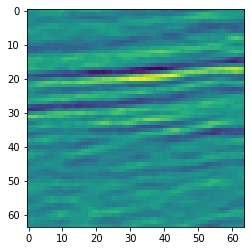

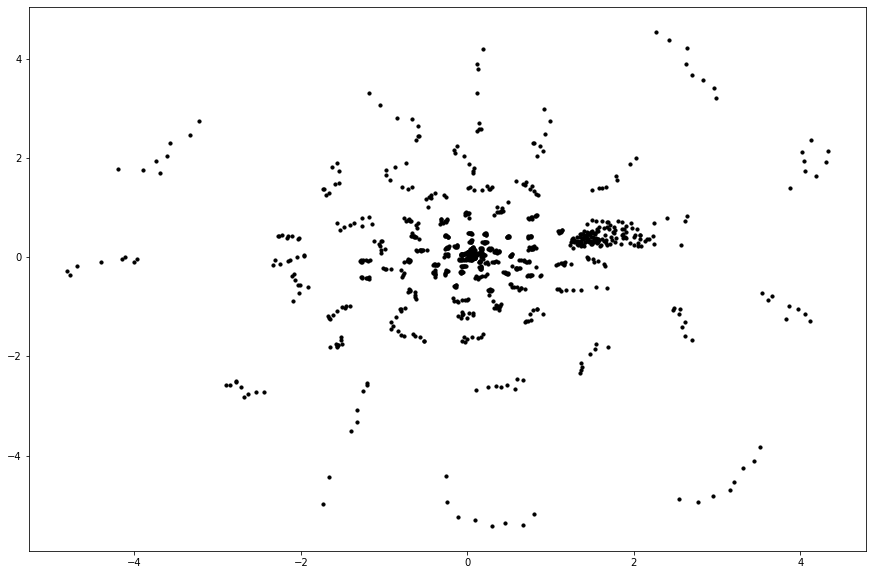

In [3]:
plt.imshow(decoded[-1][:,:,0])


# scatter data 
#scatter(encoded, np.zeros(encoded.shape[0]), encoded.shape[0], "inline", show_labels=False) 
plt.figure(figsize=(15,10))
plt.scatter(encoded[:, 0], encoded[:, 1], s=10,color="black")


dir shape (1000, 2)
nm 15 7 105000


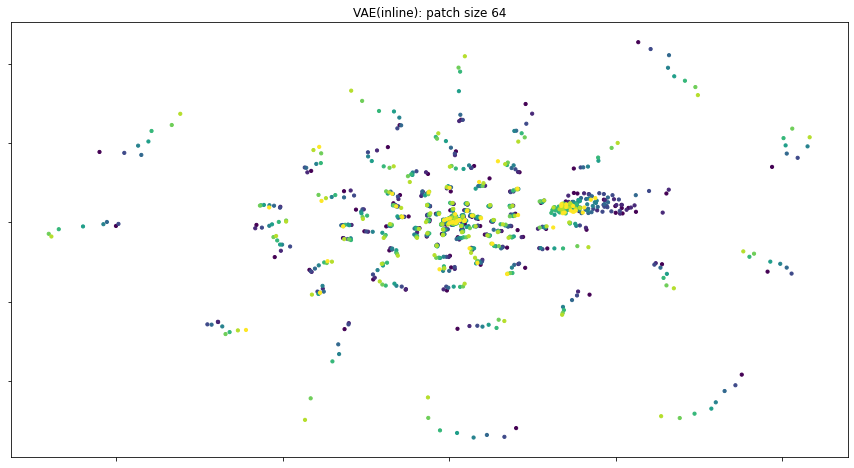

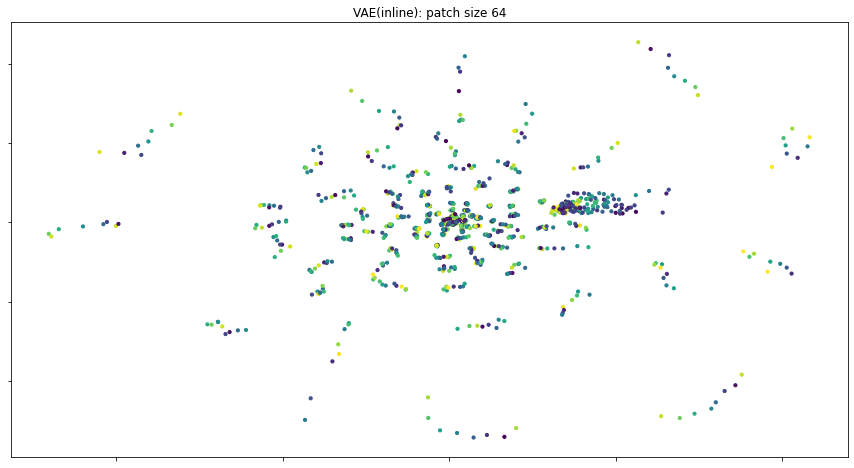

In [4]:
from matplotlib.ticker import NullFormatter

patched_labels = {}
patched_labels_per_image = {}
patched_labels_per_grid_cell={}
patched_grid_sizes = {}
patched_num_smaples = {}

# for inline 
shape = encoded.shape
n = int(960/patch_size) 
m = int(480/patch_size)
tot_patches = shape[0]*n*m
patched_num_smaples = tot_patches
patched_grid_sizes = [tot_patches, n, m]
print("dir shape", shape)
print("nm", n,m, tot_patches)
patched_labels = np.empty([tot_patches])
patched_labels_per_image = np.empty([tot_patches])
patched_labels_per_grid_cell = np.empty([tot_patches])
### TODO ADD LABELS 

# we start in inline direction 
for i in range(672):
    patched_labels[i*n*m:(i*n*m)+(n*m)] = np.arange(i*n*m,(i*n*m)+(n*m))  # these are labels per patch.... 
    patched_labels_per_image[i*n*m:(i*n*m)+(n*m)] = np.floor(np.arange(i*n*m,(i*n*m)+(n*m))/(n*m))  # these are labels per image, meaning all patches in a image get the same index.... 
    patched_labels_per_grid_cell[i*n*m:(i*n*m)+(n*m)] = np.arange(i*n*m,(i*n*m)+(n*m))%(n*m)  # these are labels per grid cell, meaning that all have a label in rthe range (0, n*m)

    
    
# narrower view of one model
learner = "VAE"
dir = "inline"
#for lb in label_colors:
i = 0 
n_points = 1000
label_colors = [patched_labels_per_image, patched_labels_per_grid_cell]

for lb in label_colors:

    data =  encoded
    #labels =patched_labels_per_image[dir][10:int(n_points/2)]#patched_labels_per_grid_cell[dir]
   
    fig = plt.figure(figsize=(15, 8))
    ax = plt.subplot()
    #plt.scatter(data[:, 0], data[:, 1], s=10,color="black")
    plt.scatter(data[:, 0], data[:, 1], s=10, c=lb[:n_points],cmap=plt.cm.get_cmap('viridis', n_points))#,color="black")
    ax.set_title("%s(%s): patch size %s" % (learner, dir, patch_size))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

    # Plot acutal images on scatterplot
    images = X

    filename = output_folder + "/_geoindex_" +str(i)+"_" + learner +"_"+ dir + "_"+ str(patch_size) + "_thumbnail__"
    plt.savefig(filename)
    i+=1




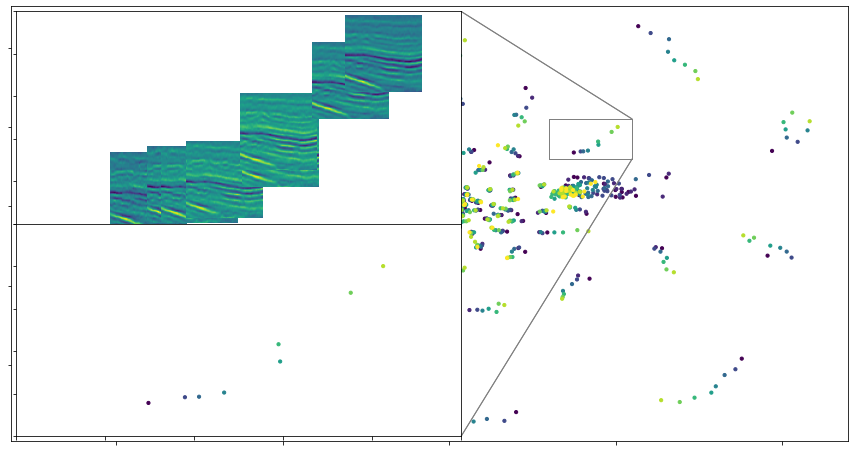

In [24]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
# narrower view of one model
ps =64
dir = "inline"
#for lb in label_colors:
i = 0 
for lb in label_colors:

    #labels =patched_labels_per_image[dir][10:int(n_points/2)]#patched_labels_per_grid_cell[dir]
   
    fig = plt.figure(figsize=(15, 8))
    ax = plt.subplot()
    #plt.scatter(data[:, 0], data[:, 1], s=10,color="black")
    plt.scatter(data[:, 0], data[:, 1], s=10, c=lb[:n_points],cmap=plt.cm.get_cmap('viridis', n_points))#,color="black")
    #ax.set_title("%s(%s): patch size %s" % (learner, dir, ps))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

    # Plot acutal images on scatterplot
    images = X[:n_points]
    #images = patched_data[dir]
    #print("img shape", images.shape)
    #plot_components(proj=data,images=[np.reshape(i, (ps, ps)).T for i in images], thumb_frac=0.05)
    filename = output_folder + "/_geoindex_" +str(i)+"_" + learner +"_"+ dir + "_"+ str(ps) 
    plt.savefig(filename)
    # # Setup zoom window
    axins = zoomed_inset_axes(ax, 5.35, loc='upper left')
    mark_inset(ax, axins, loc1=1, loc2=1, fc="none", ec="0.5")
    axins.set_xlim([1.2,2.2])
    axins.set_ylim([1.2,2.2])
    plt.yticks(visible=False)
    plt.xticks(visible=False)

    images = [np.reshape(i, (ps, ps)) for i in images]
    image_zoom=1.2
    artists = []
    for xy, j in zip(data, images):
        x0, y0 = xy
        img = OffsetImage(j, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(axins.add_artist(ab))
    axins.scatter(data[:, 0], data[:, 1], s=10, c=lb[:n_points],cmap=plt.cm.get_cmap('viridis', n_points))#,color="black")

    axins2 = zoomed_inset_axes(ax, 5.35, loc='lower left', )
    mark_inset(ax, axins2, loc1=4, loc2=4, fc="none", ec="0.5")
    axins2.set_xlim([1.2,2.2])
    axins2.set_ylim([1.2,2.2])
    plt.yticks(visible=False)
    plt.xticks(visible=False)
    plt.scatter(data[:, 0], data[:, 1], s=10, c=lb[:n_points],cmap=plt.cm.get_cmap('viridis', n_points))#,color="black")

    #axins.update_datalim(data)
    #axins.autoscale()
    filename = output_folder + "/_geoindex_" +str(i)+"_" + learner +"_"+ dir + "_"+ str(ps) + "_thumbnail__"
    plt.savefig(filename, bbox_inches='tight')
    i+=1




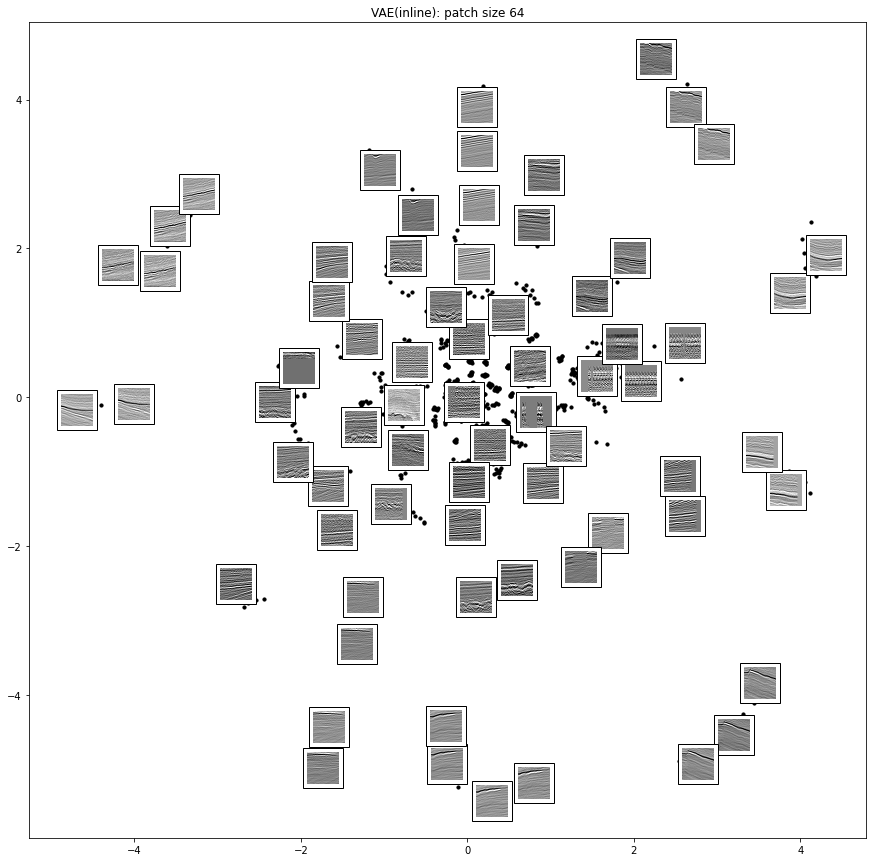

In [22]:
# plot acutal images with scatter
#scatter(encoded, np.zeros(encoded.shape[0]), encoded.shape[0], "inline", show_labels=False) 
plt.figure(figsize=(15,15))
plt.scatter(encoded[:, 0], encoded[:, 1], s=10,color="black")
images = X
plt.title("%s(%s): patch size %s" % ("VAE", "inline", patch_size))

plot_components(proj=encoded,images=[np.reshape(i, (patch_size, patch_size)).T for i in images])
plt.show()


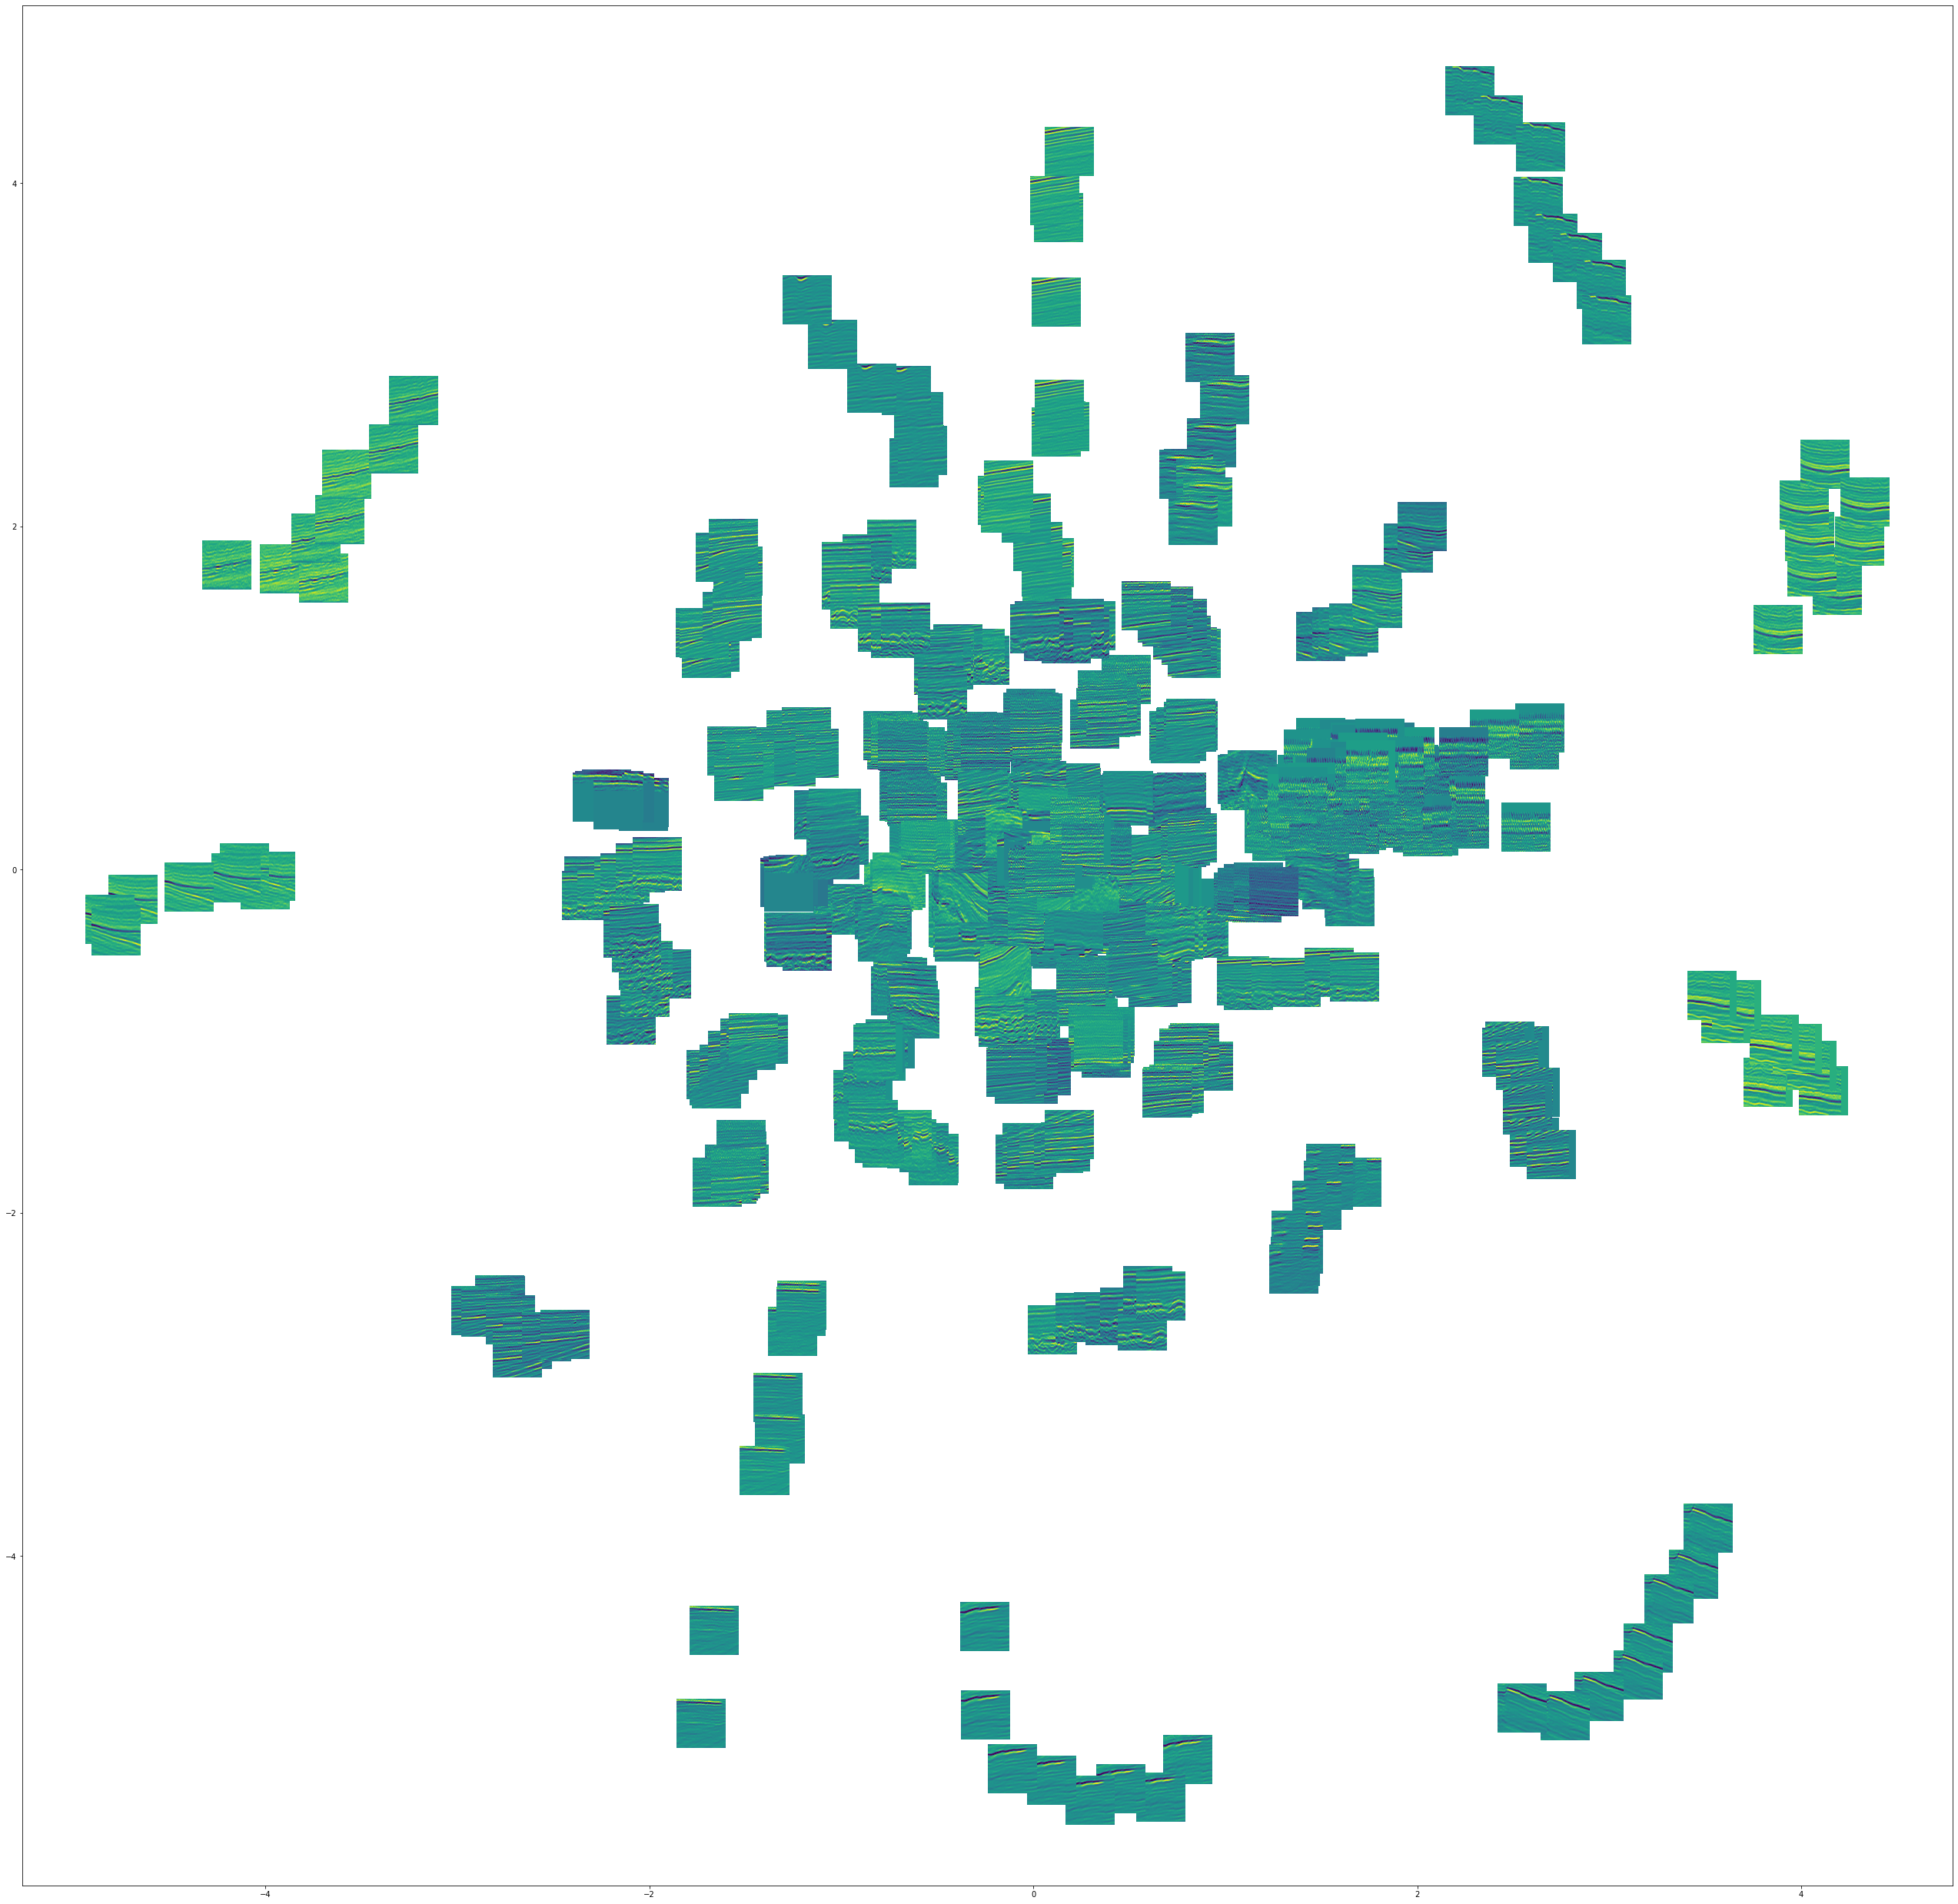

In [19]:
plots = encoded
#filename = output_folder + "/" + label +"_sliceplot_" + dir + "_"+str(ps) + ".png"
visualize_scatter_with_images(plots, images = [np.reshape(i, (patch_size, patch_size)) for i in images], image_zoom=1.)




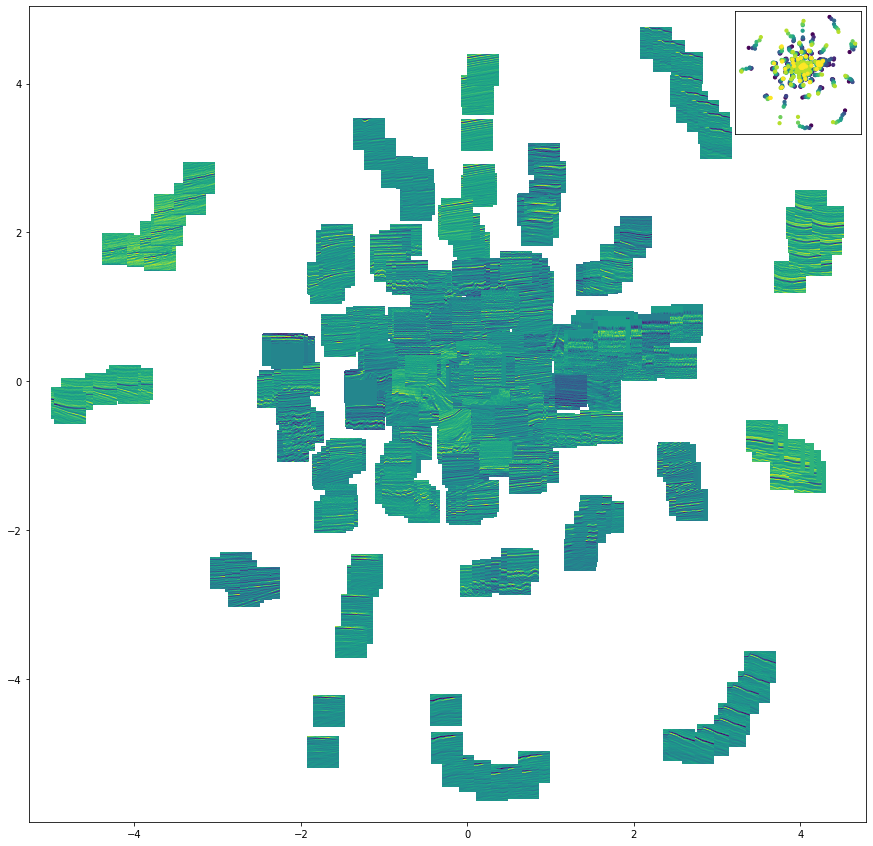

In [27]:
# visualise the scatterplot in actual images 
from mpl_toolkits.axes_grid.inset_locator import inset_axes
ps = 64
lb = label_colors[0]
DIR = "inline"
scale=0.5
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot()
images = X[:n_points]
plots = data
filename = output_folder + "/" + "VAE" +"_sliceplot_" + dir + "____"+str(ps) + ".png"
#visualize_scatter_with_images(plots, images = [np.reshape(i, (ps, ps)) for i in images], image_zoom=0.50+scale,output=filename)
images = [np.reshape(i, (ps, ps)) for i in images]
image_zoom=0.5
artists = []
for xy, j in zip(plots, images):
    x0, y0 = xy
    img = OffsetImage(j, zoom=image_zoom)
    ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
    artists.append(ax.add_artist(ab))
ax.update_datalim(plots)
ax.autoscale()
# this is an inset axes over the main axes
ins_axes = inset_axes(ax, 
                    width="15%", # width = 30% of parent_bbox
                    height="15%", # height : 1 inch
                    loc=1)
#plt.title('Probability')
plt.xticks([])
plt.yticks([])
plt.scatter(data[:, 0], data[:, 1], s=10, c=lb[:n_points],cmap=plt.cm.get_cmap('viridis', n_points))#,color="black")
plt.savefig(filename)





###  Riemann manifold 
In addition to acutal data, our R_VAE has also modeled the smooth riemann surface, referred to as the iremmann maanifold, which we use to infer meaningful distance to the latent space 


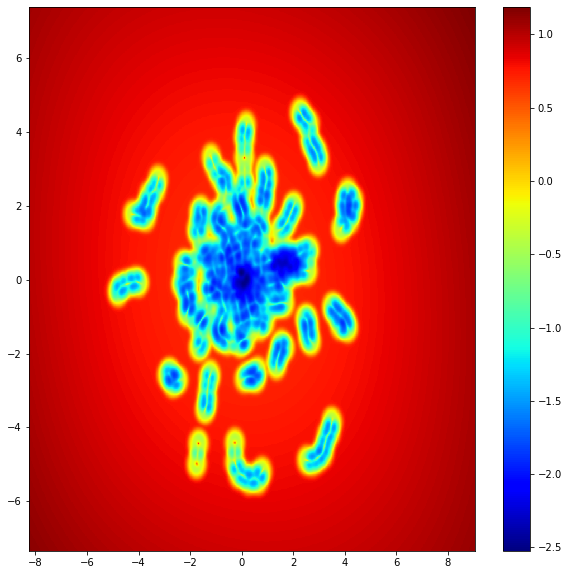

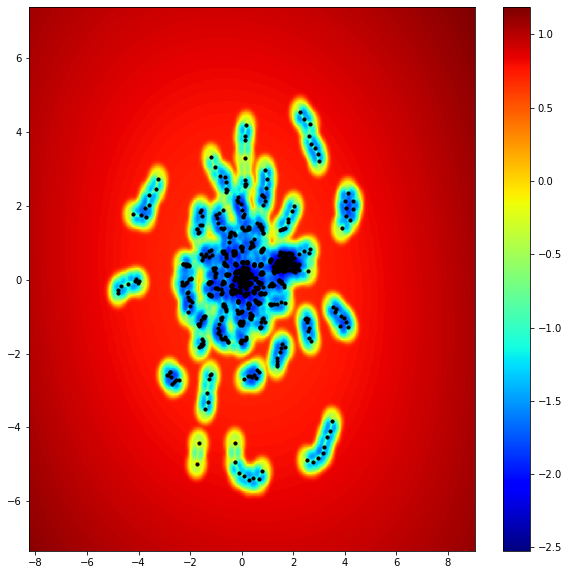

In [37]:
plt.figure(figsize=(10,10))
#plt.imshow(Z, interpolation="bilinear", cmap="brg")
MF = MF.reshape(xx.shape)

#MF= np.log10(MF)
plt.pcolormesh(xx, yy, np.log10(1/MF), cmap="jet")
#plt.scatter(encoded[:,0], encoded[:, 1], s=1, color="yellow")

#plot actuals
plt.colorbar()
#plt.show()
filename = output_folder + "/" + "VAE" +"_MF_.png"
plt.savefig(filename)
plt.show()

plt.figure(figsize=(10,10))
#MF= np.log10(MF)
plt.pcolormesh(xx, yy, np.log10(1/MF), cmap="jet")
#plt.scatter(encoded[:,0], encoded[:, 1], s=1, color="yellow")

#plot actuals
plt.colorbar()
plt.scatter(data[:, 0], data[:, 1], s=10, color="black")# c=lb[:n_points],cmap=plt.cm.get_cmap('viridis', n_points))#,color="black")

filename = output_folder + "/" + "VAE" +"_MF_scatter.png"
plt.savefig(filename)


# Now we compute the shortest path by geodesic on the reiemann manifold 

Using TensorFlow backend.






Instructions for updating:
keep_dims is deprecated, use keepdims instead

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 64, 64, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 32, 32, 32)    320         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 16, 16, 32)    9248        conv2d_1[0][0]                   
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 8192)          0           conv2d_2[0][0]                   
_____________

LOADED


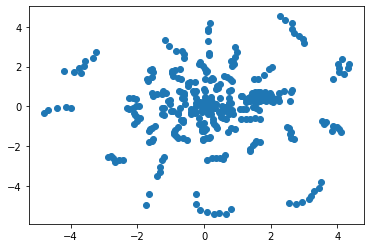

In [38]:
from scipy.stats import norm

import keras
from keras import layers
from keras.models import Model
from keras import metrics
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import Sequential
from keras.layers.core import Dense
from keras.engine.topology import Layer
from keras.initializers import RandomUniform, Initializer, Constant
from keras.losses import binary_crossentropy
from keras.optimizers import RMSprop
from scripts.rbf.rbf import InitCentersKMeans, InitCentersRandom, RBFLayer
from tensorflow.keras.constraints import NonNeg

import tensorflow as tf

import numpy as np
import pandas as pd
K.clear_session()
np.random.seed(237)

img_shape = (patch_size, patch_size, 1)    # for MNIST
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters
intermediate = 512 #1024
# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', 
                  activation='tanh', strides=(2, 2))(input_img)
x = layers.Conv2D(32, 3,
                  padding='same', 
                  activation='tanh',
                  strides=(2, 2))(x)
#x = layers.Conv2D(64, 3,
#                  padding='same', 
#                  activation='tanh')(x)
#x = layers.Conv2D(64, 3,
#                  padding='same', 
#                  activation='tanh')(x)
# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(intermediate, activation='softplus')(x) # lienar works! relu works find but is not differentiable. softplus is nearly the sme but is smoot than differentiable

# Two outputs, latent mean and (log)variance
z_mu = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)

# sampling function 
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = layers.Lambda(sampling)([z_mu, z_log_sigma])

encoder = Model(input_img, [z_mu, z_log_sigma, z], name='encoder')
encoder.summary()
x = layers.Dense(intermediate, activation='tanh')#(z)#(decoder_input)


# Expand to 784 total pixels
xx1 = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='tanh')#(x)#(decoder_input)

# reshape
xx2 = layers.Reshape(shape_before_flattening[1:])#(xx1)

# use Conv2DTranspose to reverse the conv layers from the encoder
xx3 = layers.Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='tanh',
                           strides=(2, 2))#(xx2)
xx4 = layers.Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='tanh',
                           strides=(2, 2))#(xx3)
xx5 = layers.Conv2DTranspose(3, 3,
                           padding='same', 
                           activation='tanh',
                           strides=(1, 1))#(xx4)
_x_decoded_mean = layers.Conv2D(1, 3,
                  name="mean",
                  padding='same', 
                  activation='linear')#(xx5)
_x_decoded_var = layers.Conv2D(1, 3,
                  name="var",
                  padding='same', 
                  activation='softplus')#(xx5) we want to restrict it to only positive numbers, so we use ReLU activation to squash it to our range.

# create decoder structure from z 
#__xx5 = xx5(xx4(xx3(xx2(xx1(x(z))))))
#z_decoded = _x_decoded_mean(__xx5) # used in vae model model       #x_decoded_mean#decoder(z)
#x_decoded_var = _x_decoded_var(__xx5) # used in loss  #x_decoded_mean#decoder(z)
#x_decoded_var.trainable = False




# define decoder as a model for later use 
# decoder takes the latent distribution sample as input
decoder_input = layers.Input(K.int_shape(z)[1:]) # input 
print(decoder_input, K.int_shape(z)[1:], z)

decoder_xx5 = xx5(xx4(xx3(xx2(xx1(x(decoder_input)))))) # shared layers between mean and variance
decoder_ouput_mean = _x_decoded_mean(decoder_xx5) # ouput mean
decoder_ouput_var = _x_decoded_var(decoder_xx5) # ouput var 


# create the actual 
decoder = Model(decoder_input, [decoder_ouput_mean, decoder_ouput_var], name='decoder')
decoder.get_layer("var").trainable = False
for l in decoder.layers:
    print(l.name, l.trainable)
decoder.summary()

# apply the decoder to the sample from the latent distribution to get both mean and var 
z_decoded_mean, z_decoded_var = decoder(encoder(input_img)[2])

import math
var_epsilon = 0.010
# when using only var__epsilon (static variance) it seems as if the network is better at learning between training points
# this comes to show in the plots far below.
# this is becaus eneural net variance will make eveything more complex, and compressed, and give arbitrary variance inbetweeen 
# as descibed in "goemtric gmanifold paper"

def kl_loss(x, decoder_ouput_mean):
    kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1) # want this to be less originally
   
    return K.mean(kl_loss)

def logx_loss(x, decoder_ouput_mean):
    loss = (  0.5 * math.log(2 * math.pi)
            + 0.5 * K.log(var_epsilon)  # NOW IT IS STATIC use "z_decoded_var" if not static
            + 0.5 * K.square(x - decoder_ouput_mean) / ( var_epsilon)) # NOW IT IS STATIC use "z_decoded_var" if not static
    loss = K.sum(loss, axis=-1)
    #x = K.flatten(x)
    #x_decoded_mean = K.flatten(x_decoded_mean)
    #loss = metrics.binary_crossentropy(x, x_decoded_mean)
    return K.mean(loss)

def vae_loss(x, decoder_ouput_mean):
    return logx_loss(x, decoder_ouput_mean) + kl_loss(x, decoder_ouput_mean)
    #x = K.flatten(x)
    #z_decoded = K.flatten(z_decoded)
    # KL divergence
    #kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1) # want this to be less originally
    # Reconstruction loss
    #xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)# self.logx_loss(x, z_decoded)#

    #return K.mean(xent_loss + kl_loss)

vae = Model(input_img, z_decoded_mean)
vae.compile(optimizer="rmsprop", loss=vae_loss)
vae.summary()



######### CREATE RBF VARIANCE NETWORK ####################
rbf_decoder_input = layers.Input(K.int_shape(z)[1:]) # input 

rbflayer = RBFLayer(350,
                    name="rbf",
                    initializer=InitCentersKMeans(encoded),#InitCentersRandom(X),
                    betas=20, # determine the sharpness of the gausian https://towardsdatascience.com/most-effective-way-to-implement-radial-basis-function-neural-network-for-classification-problem-33c467803319
                    input_shape=(latent_dim,))

rbfoutput = layers.Dense(1024, name="rb_dense", activation='linear',kernel_constraint=NonNeg(), bias_constraint=NonNeg())#activation='tanh')#(z)#(decoder_input)
reshapelayer = layers.Reshape((32,32,1)) # subsampled image of 64*64  (i guess)
convT1 = layers.Conv2DTranspose(1, 3,
                           padding='same', #TODO NEED TO CLIP WEIGHT SO IT IS POSITIVE
                           activation='linear',
                           strides=(2, 2),
                           kernel_constraint=NonNeg(), bias_constraint=NonNeg())
conv = layers.Conv2D(1, 3,
                     name="var",
                  padding='same', 
                  activation='linear', strides=(1, 1),
                  kernel_constraint=NonNeg(), bias_constraint=NonNeg())

# create non-trainable mean-network from existing
decoder_mean = vae.get_layer("decoder")
mean_network = Model(inputs=decoder_mean.inputs, outputs=decoder_mean.layers[-2].output,name='mean_network')## decoder(rbf_decoder_input)
for l in mean_network.layers:
    l.trainable = False
    print(l.name, l.trainable)
rbf_output_mean= mean_network(rbf_decoder_input)

# create new rb network 
rbf_network = rbfoutput(rbflayer(rbf_decoder_input))
rbf_output_var = conv(convT1(reshapelayer(rbf_network)))

# add both as a model 
rbf_decoder = Model(rbf_decoder_input, [rbf_output_mean, rbf_output_var],name='decoder')
rbf_decoder.summary()
print("RBF ENCODER")
for l in rbf_decoder.layers:
    l.trainable = True
    print(l.name, l.trainable)   
# set encoder to non-trainable 
rbf_decoder.get_layer("mean_network").trainable = False
rbf_decoded_mean, rbf_decoded_var = rbf_decoder(encoder(input_img)[2]) ##### COMMMENT FOR SAMPLING #####


##### UNCOMMMENT FOR SAMPLING #####
# sample vector from the latent distribution
#print("(K.shape(z_mu)[0], 1)", (K.shape(z_mu)[0], 1))
#def sampling(args):
#    z_mu, z_log_sigma = args
#    epsilon = K.random_normal(shape=(K.shape(z_mu)),
#                              mean=0., stddev=1.)
#    return z_mu + K.exp(z_log_sigma) * epsilon

#x_sampled = layers.Lambda(sampling)([rbf_output_mean, rbf_output_var])
# create sampled model
#y_sampled = Model(inputs=rbf_decoder.inputs, outputs=[rbf_output_mean, rbf_output_var, x_sampled], name='y_sampled')
#print("RBF ENCODER")
#for l in y_sampled.layers:
#    l.trainable = True
#    print(l.name, l.trainable)   
# set encoder to non-trainable 
#y_sampled.get_layer("mean_network").trainable = False
#y_sampled.summary()
#_,rbf_output_var,sampled_ouput = y_sampled(encoder(input_img)[2])
################################# 
    
    
######### RE-STATE LOSS SO WE ONLY TRAIN RBF ####################
import math
var_epsilon = 0.00010
learning_rate = 0.00001
# when using only var__epsilon (static variance) it seems as if the network is better at learning between training points
# this comes to show in the plots far below.
# this is becaus eneural net variance will make eveything more complex, and compressed, and give arbitrary variance inbetweeen 
# as descibed in "goemtric gmanifold paper"

def kl_loss(x, rbf_decoded_mean):
    kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1) # want this to be less originally
   
    return K.mean(kl_loss)

def logx_loss(x, rbf_decoded_mean):
    loss = (  0.5 * math.log(2 * math.pi)
            + 0.5 * K.log(rbf_decoded_var +  var_epsilon)  ##### change to rbf_output_var FOR SAMPLING #####
            + 0.5 * K.square(x - rbf_decoded_mean) / (rbf_decoded_var +  var_epsilon)) ##### change to rbf_output_var FOR SAMPLING #####

    loss = K.sum(loss, axis=-1)
    #x = K.flatten(x)
    #x_decoded_mean = K.flatten(x_decoded_mean)
    #loss = metrics.binary_crossentropy(x, x_decoded_mean)
    return K.mean(loss)

def rbf_vae_loss_with_variance(x, rbf_decoded_mean):
    return logx_loss(x, rbf_decoded_mean) + kl_loss(x, rbf_decoded_mean)
    #x = K.flatten(x)
    #z_decoded = K.flatten(z_decoded)
    # KL divergence
    #kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1) # want this to be less originally
    # Reconstruction loss
    #xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)# self.logx_loss(x, z_decoded)#

    #return K.mean(xent_loss + kl_loss)

######### CREATE NEW RBF VAE ####################

vae = Model(input_img, rbf_decoded_mean)
#vae = Model(inputs=input_img, outputs=sampled_ouput)##### UNCOMMMENT FOR SAMPLING #####


# load the weights if it has not been loaded already....
#filename =output_folder+"/model_64_64_8x8_1_000_tanh_variance_static.h5"
#rbf_vae.load_weights(filename)

# compile model to include loss 
optimizer = Adam(lr=learning_rate)
vae.compile(optimizer=optimizer, loss=rbf_vae_loss_with_variance)
vae.summary() 
weight_path = input_folder+"/rbf350_weight_64x64_2_1000_softplus_varstatic.h5"
model_path = input_folder+"/rbf350_model_64x64_2_1000_softplus_varstatic.h5"
#vae.save_weights(weight_path)
#vae.save(model_path)
#print("Saved model to disk")

vae.load_weights(weight_path)
#vae = keras.models.load_model(model_path, custom_objects={'vae_loss': vae_loss}, compile=False)
print("LOADED")



In [39]:
# Now we have a vae, we can calculate the latent space riemann 
import networkx as nx

from scripts.riemannian.riemannian_latent_space import RiemannianMetric, RiemannianTree
from scripts.rbf.rbf import InitCentersKMeans, InitCentersRandom, RBFLayer

import tensorflow as tf
import keras 
from scipy.stats import norm

session = tf.Session()
session.run(tf.global_variables_initializer())


model_input = rbf_decoder.inputs[0]
model_output = rbf_decoder.outputs[0]
model_ouput_var = rbf_decoder.outputs[1]

rmetric = RiemannianMetric(x=model_output, z=model_input, session=session)
rmetric.create_tf_graph(output_dim=64)

z = X
# we randomly selects 100 points of the data to create the graph
n_nodes = 100
n_steps = 100
n_neighbors =10
graph_indexes = np.random.choice(encoded.shape[0], n_nodes)
print("graph_indexes", graph_indexes.shape)
z_graph_encoded = encoded[graph_indexes]
print("z.shape", z.shape, z_graph_encoded.shape)
# we initi the riemanntree 
rTree = RiemannianTree(rmetric)
# we then calculate the eucledian and riemann/geodesic length for each edge 
G = rTree.create_riemannian_graph(z_graph_encoded, n_steps=n_steps, n_neighbors=n_neighbors)


nklnlnnkl Tensor("mean_network/mean/BiasAdd:0", shape=(?, ?, ?, 1), dtype=float32) Tensor("input_3:0", shape=(?, 2), dtype=float32)
dsfsdsdfds Tensor("strided_slice:0", shape=(?, ?, 1), dtype=float32) Tensor("input_3:0", shape=(?, 2), dtype=float32)


  0%|          | 0/100 [00:00<?, ?it/s]

graph_indexes (100,)
z.shape (1000, 64, 64, 1) (100, 2)


 21%|██        | 21/100 [00:26<01:30,  1.14s/it]/home/andykamp/master/quantify_seismic_similarity/scripts/riemannian/riemannian_latent_space.py:136: RuntimeWarning: divide by zero encountered in true_divide
  edge_attr = {'weight_riemann': float(1/L_riemann),
/home/andykamp/master/quantify_seismic_similarity/scripts/riemannian/riemannian_latent_space.py:137: RuntimeWarning: divide by zero encountered in double_scalars
  'weight_euclidean': float(1/L_euclidean),
 28%|██▊       | 28/100 [00:33<01:19,  1.10s/it]/home/andykamp/master/quantify_seismic_similarity/scripts/riemannian/riemannian_latent_space.py:136: RuntimeWarning: divide by zero encountered in true_divide
  edge_attr = {'weight_riemann': float(1/L_riemann),
/home/andykamp/master/quantify_seismic_similarity/scripts/riemannian/riemannian_latent_space.py:137: RuntimeWarning: divide by zero encountered in double_scalars
  'weight_euclidean': float(1/L_euclidean),
 53%|█████▎    | 53/100 [00:59<00:47,  1.02s/it]/home/andykamp/maste

nodeeesss [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
{99: {'weight_riemann': 83.17874871560963, 'weight_euclidean': 36.78035480320923, 'distance_riemann': 0.01202230155467987, 'distance_euclidean': 0.027188427228351426}, 47: {'weight_riemann': 53.92701789531806, 'weight_euclidean': 23.90072674410936, 'distance_riemann': 0.018543580546975136, 'distance_euclidean': 0.04183973193394476}, 73: {'weight_riemann': 46.934797748056724, 'weight_euclidean': 22.93705512416605, 'distance_riemann': 0.021306153386831284, 'distance_euclidean': 0.043597575825957656}, 37: {'weight_riemann': 48.0974723135627, 'weight_euclidean': 21.287347441056674, 'distance_riem

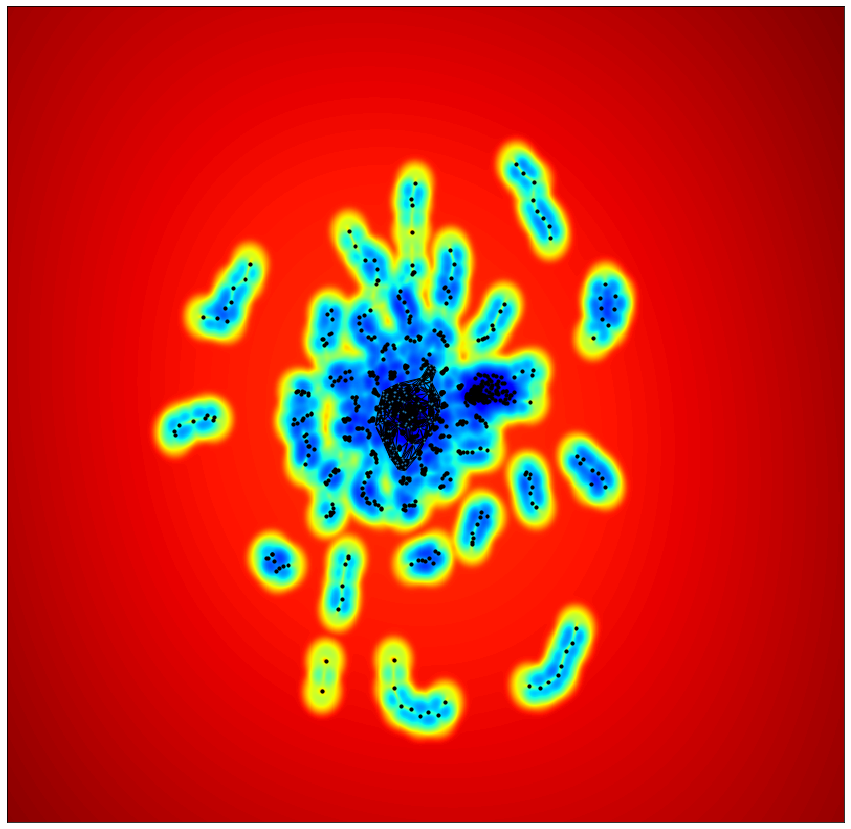

In [91]:
# saving graph
import json
import networkx as nx
from networkx.readwrite import json_graph

# add nodes, edges, etc to G ...
print("nodeeesss", G.nodes())
print(G[0])
def save(G, fname):
    #json_G = json_graph.node_link_data(G)
    #with open(fname, 'w') as f:
    #    json.dump(json_G, f)
    nx.write_gpickle(G,fname)

    #json.dump(dict(nodes=[[n, G.node[n]] for n in G.nodes()],
    #               edges=[[u, v, G.edge[u][v]] for u,v in G.edges()]),
    #          open(fname, 'w'), indent=2)

def load(fname):
    G = nx.read_gpickle(fname)
    #d = json.load(open(fname))
    #G.add_nodes_from(d['nodes'])
    #G.add_edges_from(d['edges'])
    return G

filename = output_folder + f'mg_graph_{n_nodes}_{n_steps}_{n_neighbors}'

save(G, filename)
temp_G = load(filename)
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot()

ax.pcolormesh(xx, yy, np.log10(1/MF), cmap="jet") # plot non-logaritmic values ( inverse)

ax.scatter(data[:, 0], data[:, 1], s=10, color="black")# c=lb[:n_points],cmap=plt.cm.get_cmap('viridis', n_points))#,color="black")

nx.draw_networkx(temp_G, ax=ax, node_size=1, with_labels=False)


In [54]:
import tqdm
import cv2

# we can use djistra on non--binary grids 
# for source code see https://bougui505.github.io/2016/08/31/compute_the_shortest_path_on_a_grid_using_python.html
def dijkstra(V, start):
    mask = V.mask
    visit_mask = mask.copy() # mask visited cells
    m = np.ones_like(V) * np.inf # Return an array of infinity with the same shape and type as a given array.
    connectivity = [(i,j) for i in [-1, 0, 1] for j in [-1, 0, 1] if (not (i == j == 0))]
    cc = start # np.unravel_index(V.argmin(), m.shape) # current_cell
    m[cc] = 0
    P = {}  # dictionary of predecessors 
    #while (~visit_mask).sum() > 0:
    for _ in tqdm.trange(V.size):
        #print cc
        neighbors = [tuple(e) for e in np.asarray(cc) - connectivity 
                     if e[0] > 0 and e[1] > 0 and e[0] < V.shape[0] and e[1] < V.shape[1]]
        neighbors = [ e for e in neighbors if not visit_mask[e] ]
        tentative_distance = np.asarray([V[e]-V[cc] for e in neighbors])
        for i,e in enumerate(neighbors):
            d = tentative_distance[i] + m[cc]
            if d < m[e]:
                m[e] = d
                P[e] = cc
        visit_mask[cc] = True
        m_mask = np.ma.masked_array(m, visit_mask)
        cc = np.unravel_index(m_mask.argmin(), m.shape)
    return m, P

def shortestPath(start, end, P):
    Path = []
    step = end
    while 1:
        Path.append(step)
        if step == start: break
        #print(step)
        step = P[step]
    Path.reverse()
    return np.asarray(Path)

def convert_proj_to_coord(proj, xx, yy):
    x_max = xx.max()
    x_min = xx.min()
    y_min = yy.min()
    y_max = yy.max()
    coords = [0,0]
    print("cxx[0]", yy[0,0])
    for i, icoord in enumerate(xx[0]):
        if proj[0]<=icoord:
            coords[0]= i
            print("found proj x", i, icoord)
            break
    for j, jcoord in enumerate(yy[:,-1]):
        #print(j, jcoord)
        if proj[1]<=jcoord:
            coords[1]= j
            print("found proj y", j, jcoord)
            break
    print("coords", coords)
    return coords
    

    
def convert_coord_to_proj(path, down_factor, olddim,newdim, xx, yy):
    path  = path * int(olddim/newdim)#int((1-down_factor)*xx.shape[0])
    proj_points_x = []
    proj_points_y = []
    for coord in path:
        proj_points_x.append(xx[coord[0], coord[1]])
        proj_points_y.append(yy[coord[0], coord[1]])
    return proj_points_x, proj_points_y

def shortest_path_dijkstra(start, end, grid, down_factor=0.2):
    print(int(start[1]*down_factor), int(start[0]*down_factor))
    start = (int(start[1]*down_factor), int(start[0]*down_factor))
    end =  (int(end[1]*down_factor), int(end[0]*down_factor))
    print(start, end)
    olddim = grid.shape[0]
    newdim = int(olddim*down_factor)
    print("newshape", olddim, newdim, int(olddim/newdim))
    res = cv2.resize(grid, dsize=(newdim, newdim), interpolation=cv2.INTER_CUBIC)
    V=1/res
    V = np.ma.masked_array(V, V>2000)
    #plt.contourf(V, 40)
    #plt.colorbar()
    D, P = dijkstra(V, start)
    path = shortestPath(start, end, P)
    #V = cv2.resize(V, dsize=(800,800), interpolation=cv2.INTER_CUBIC)
   
    return convert_coord_to_proj(path, down_factor, olddim,  newdim,xx, yy)

In [55]:
down_factor = 0.5
proj_coord = convert_proj_to_coord([3, 3], xx, yy) 
proj_coord= convert_coord_to_proj([proj_coord], down_factor, 800,  160, xx, yy)

print("proj", proj_coord)
start = (400,500)
end = (100,500)
path = shortest_path_dijkstra(start, end, MF, down_factor=0.2)
fig = plt.figure(figsize=(20,20))
plt.pcolormesh(xx, yy, np.log10(1/MF), cmap="jet")
plt.plot(path[0],path[1],'r.-')
plt.scatter(proj_coord[0], proj_coord[1], s =300)
plt.colorbar()
plt.show()

  2%|▏         | 596/25600 [00:00<00:04, 5952.16it/s]

cxx[0] -7.340385437011719
found proj x 520 3.0215066329707785
found proj y 562 3.0154377336943714
coords [520, 562]
proj ([3.9319560942572256, 3.9319560942572256, 3.9319560942572256, 3.9319560942572256, 3.9319560942572256], [2.2415150056344846, 2.2415150056344846, 2.2415150056344846, 2.2415150056344846, 2.2415150056344846])
100 80
(100, 80) (100, 20)
newshape 800 160 5


100%|██████████| 25600/25600 [00:04<00:00, 6116.68it/s]


  2%|▏         | 634/25600 [00:00<00:03, 6337.00it/s]

number_of_nodes 100
number_of_edges 644
z1z2 [ 0.14416617 -0.19350085] [-2.7744768 -2.5110528]
cxx[0] -7.340385437011719
found proj x 388 0.1600940403562312
found proj y 388 -0.19081356826801255
coords [388, 388]
cxx[0] -7.340385437011719
found proj x 253 -2.766350656635919
found proj y 263 -2.494155020827196
coords [253, 263]
end [253, 263]
77 77
(77, 77) (52, 50)
newshape 800 160 5


100%|██████████| 25600/25600 [00:04<00:00, 6156.35it/s]


ecl : [35, 33, 59, 28] 3.757250239580051
rie : [35, 33, 59, 28] 1.6941763162612915


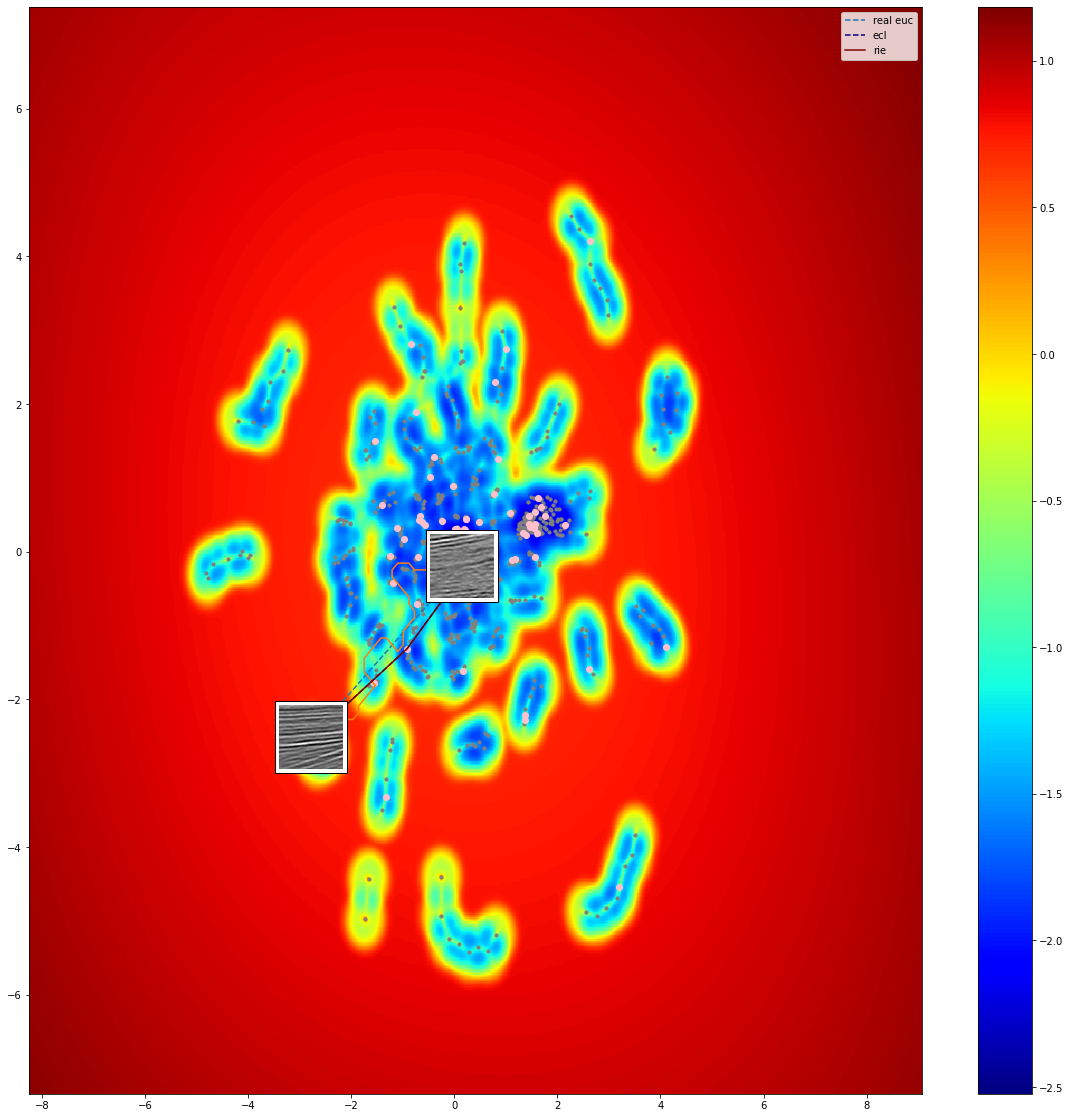

In [56]:
# # can use G to do shortest path finding now

import matplotlib.patheffects as PathEffects
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

print("number_of_nodes", G.number_of_nodes())
print("number_of_edges", G.number_of_edges())
#print("nodes", G.nodes())
#print("edges", G.edges())

# plotting each graph
#q = rmetric.riemannian_distance_along_line(np.array([[-10, 0]]), np.array([[5, 0]]), n_steps=100)
#print(q)

graph_index_start = 35#8
graph_index_end = 28#6
z1_encoded = z_graph_encoded[graph_index_start]
z2_encoded = z_graph_encoded[graph_index_end]
print("z1z2", z1_encoded, z2_encoded)


shortest_path_eucl = nx.algorithms.shortest_paths.generic.shortest_path(G, graph_index_start, graph_index_end, "distance_euclidean")
shortest_path_rie = nx.algorithms.shortest_paths.generic.shortest_path(G, graph_index_start, graph_index_end, "distance_riemann")

#shortest_path_eucl = nx.algorithms.shortest_paths.astar_path(G, 0, 5, weight="weight_euclidean")
#shortest_path_rie = nx.algorithms.shortest_paths.astar_path(G, 0, 5, weight="weight_riemann")

def plotPath(data_graph_encoded,  data, pathList, G, show_labels=False):
    fig = plt.figure(figsize=(20,20))
    ax1 = fig.add_subplot(111)
    
    
    # dijstra shortest path 

    start = convert_proj_to_coord(z1_encoded, xx, yy) 
    end = convert_proj_to_coord(z2_encoded, xx, yy) 
    print("end", end)
    geodesic = shortest_path_dijkstra(start, end, MF, down_factor=0.2)
    
    
        
        
    # plot all nodes
    #im1 = ax1.pcolormesh(xx, yy, MF, cmap="brg")  # plit logaritmic (scale does not show corrct amounts )
    im1 = ax1.pcolormesh(xx, yy, np.log10(1/MF), cmap="jet") # plot non-logaritmic values ( inverse)
    #im1 = ax1.pcolormesh(xx, yy, 1/MF)# cmap="brg")     # plot original values (not inverse)

    ax1.scatter(data[:,0], data[:,1], color="grey", s=10)
    ax1.scatter(data_graph_encoded[:,0], data_graph_encoded[:,1], color="pink")
    if show_labels:
        for i in range(data_graph_encoded.shape[0]):
                # Position of each label.
                xtext, ytext = data_graph_encoded[i]#np.median(data_graph_encoded[labels == i, :], axis=0)
                txt = ax1.text(xtext, ytext, str(i), fontsize=10)
                txt.set_path_effects([
                    PathEffects.Stroke(linewidth=5, foreground="w"),
                    PathEffects.Normal()])
                #txts.append(txt)
    ax1.scatter(z1_encoded[0], z1_encoded[1], color="red")
    ax1.scatter(z2_encoded[0], z2_encoded[1], color="yellow")
    # plot actual euclidian
    ax1.plot([z1_encoded[0], z2_encoded[0]], [ z1_encoded[1], z2_encoded[1]], linestyle="dashed", label="real euc")
    ax1.plot(geodesic[0],geodesic[1] )
    

    n = len(pathList)
    colors = plt.cm.jet(np.linspace(0,1,n))
    i = 0 
    for path in pathList:
        # plot line trough shortest path
        if i == 0: 
            label = "ecl"
            linestyle= "dashed"
        else:
            label= "rie"
            linestyle= "solid"
        shortest_dist_eucl = []
        shortest_dist_rie = []
        shortest_dist_eucl_val = 0
        shortest_dist_rie_val = 0
        # find
        for indx in range(len(path)-1):
            fr = path[indx]
            to = path[indx+1]
            edge = G[fr][to]
            #print(fr, to, edge)
            if i == 0:
                shortest_dist_eucl.append(edge["distance_euclidean"])
                shortest_dist_eucl_val += edge["distance_euclidean"]
            else:
                shortest_dist_rie.append(edge["distance_riemann"])
                shortest_dist_rie_val += edge["distance_riemann"]
        if i == 0:
            print(label, ":", path,  shortest_dist_eucl_val)
        else:
            print(label, ":", path,  shortest_dist_rie_val, )




        ax1.plot(data_graph_encoded[path,0], data_graph_encoded[path,1], color=colors[i], linestyle=linestyle, label=label  )
        handles, labels = ax1.get_legend_handles_labels()
        ax1.legend(handles, labels)
        #plt.colorbar()


        i+=1
    fig.colorbar(im1)
    return ax1 





pathList = [shortest_path_eucl, shortest_path_rie]

ax = plotPath(z_graph_encoded, encoded, pathList, G)

# plot the start and finish image
imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(decoded[graph_indexes[graph_index_start]][:,:,0],cmap='gray'), z1_encoded)
ax.add_artist(imagebox)
imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(decoded[graph_indexes[graph_index_end]][:,:,0],cmap='gray'), z2_encoded)
ax.add_artist(imagebox)

  
#x.plot(path[:,1], path[:,0], 'r.-')
## plot along path 
#for i in pathList[0]:
#    imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(decoded[graph_indexes[i]][:,:,0]), z_graph_encoded[i])
#    ax.add_artist(imagebox)


(1000, 64, 64, 1) [[35, 33, 59, 28], [35, 33, 59, 28]]


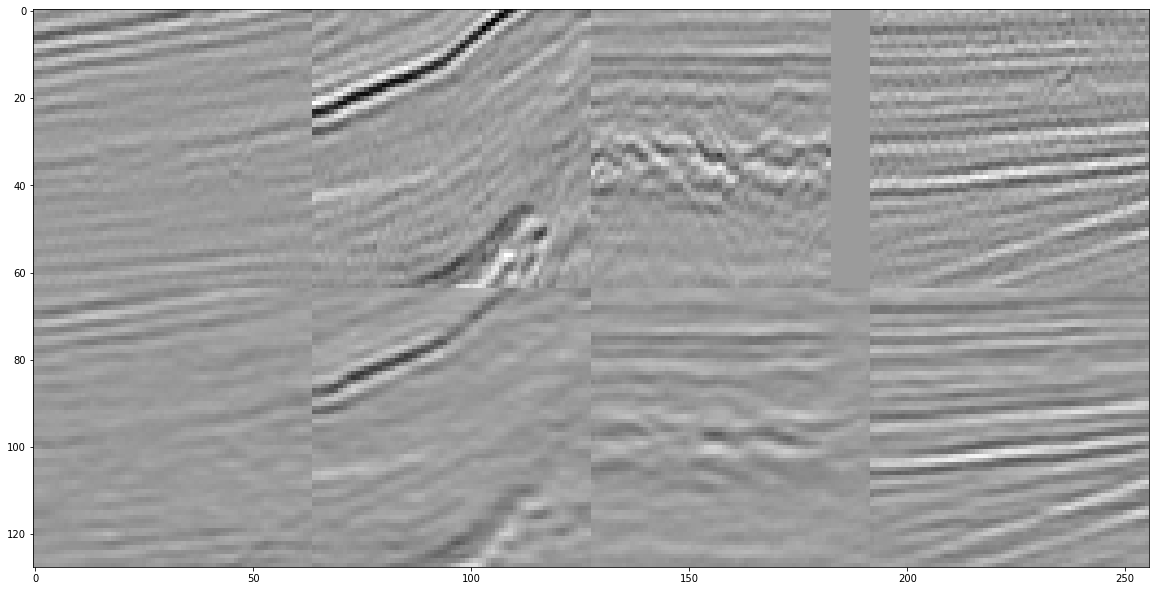

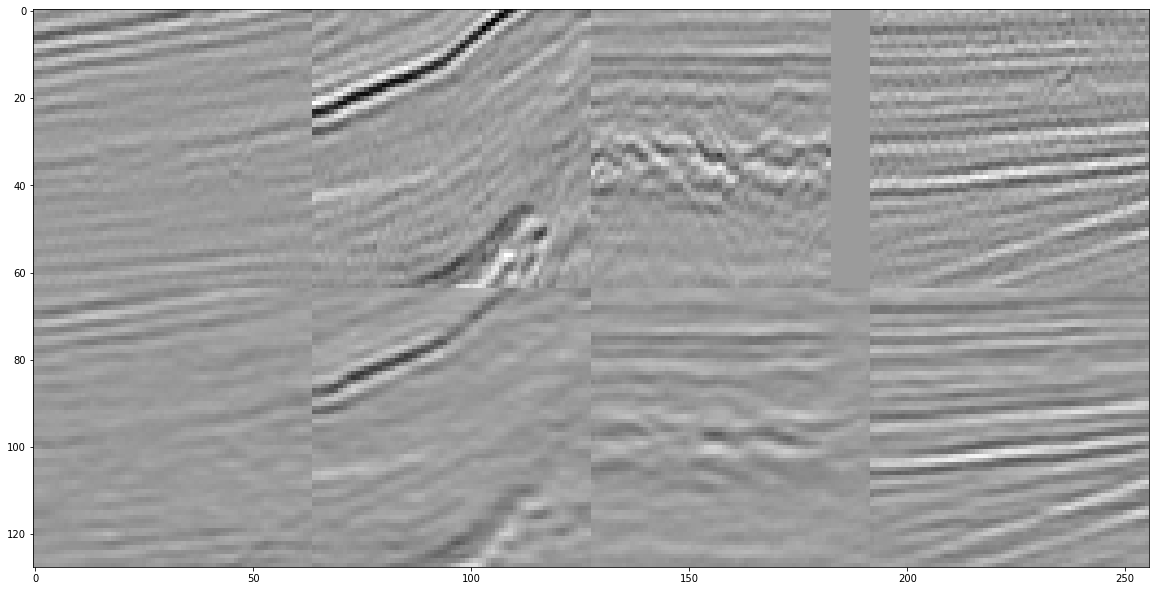

NameError: name 't' is not defined

In [17]:
#show interpolation along the lines vs pixel space 
print(X.shape, pathList)
# Put final image together

resultImage = None
for path in pathList:
    resultLatent = None
    resultImage = None
    fig = plt.figure(figsize=(20,20))
    for i in path:
        indx = graph_indexes[i]
        # horisontally stach each image so we show them on one line 
        interpolatedImage = X[indx]
        interpolatedImage = interpolatedImage.reshape(patch_size,patch_size)
        #interpolatedImage = interpolatedImage.astype(np.uint8)
        resultImage = interpolatedImage if resultImage is None else np.hstack([resultImage,interpolatedImage])

        reconstructedImage = decoded[indx]
        reconstructedImage = reconstructedImage.reshape(patch_size,patch_size)
        #reconstructedImage = reconstructedImage.astype(np.uint8)
        resultLatent = reconstructedImage if resultLatent is None else np.hstack([resultLatent,reconstructedImage])
        result = np.vstack([resultImage,resultLatent])
    plt.imshow(result,cmap='gray')
    plt.show()
    
# show straight line interpolation 
# discretize the  along the line
n_steps = [len(pathList[0])]
dt = t[1] - t[0]
the_line = np.concatenate([_ * z1_encoded + (1 - _) * z2_encoded for _ in t])
xs = the_line[::2]
ys = the_line[1:][::2]

fig = plt.figure(figsize=(20,20))
resultLatent = None
resultImage = None
for coord  in zip(np.flip(xs), np.flip(ys)):
    coord = np.asarray([coord])
    # horisontally stach each image so we show them on one line 
    interpolatedImage = decoder.predict(coord)[0]#X[i]
    interpolatedImage = interpolatedImage.reshape(patch_size,patch_size)
    #interpolatedImage = interpolatedImage.astype(np.uint8)
    resultImage = interpolatedImage if resultImage is None else np.hstack([resultImage,interpolatedImage])
plt.imshow(resultImage,cmap='gray')
plt.show()

geodesic = shortest_path_dijkstra(start, end, MF, down_factor=0.2)
print(len(geodesic[0]))
# show the shortest path interpolation 
geodesic_samples_x = geodesic[0][:6]
geodesic_samples_y = geodesic[1][:6]
print(geodesic_samples_x, geodesic_samples_y)
fig = plt.figure(figsize=(20,20))
resultLatent = None
resultImage = None
for coord  in zip(np.flip(geodesic_samples_x), np.flip(geodesic_samples_y)):
    coord = np.asarray([coord])
    # horisontally stach each image so we show them on one line 
    interpolatedImage = decoder.predict(coord)[0]#X[i]
    interpolatedImage = interpolatedImage.reshape(patch_size,patch_size)
    #interpolatedImage = interpolatedImage.astype(np.uint8)
    resultImage = interpolatedImage if resultImage is None else np.hstack([resultImage,interpolatedImage])
plt.imshow(resultImage, cmap='gray')
plt.show()


